In [ ]:
# default_exp core

In [ ]:
#hide
import sys
sys.path.append('..')
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.all import *
from fastai2.basics import *
import pandas as pd
import numpy as np

# Core functions

> API details.

## Utils

In [ ]:
# export
from git import Repo
from nbdev.export import Config as nb_Config
from nbdev.export import *

def git_add(fname, commit_msg='.'):
    repo = Repo(nb_Config().nbs_path.parent)
    notebook2script(fname)
    nb = read_nb(fname)
    default = find_default_export(nb['cells'])
    py = [os.path.join(nb_Config().lib_path,*default.split('.'))+'.py',
          os.path.join(nb_Config().nbs_path,fname)
         ]
    repo.index.add(py)
    repo.index.commit(commit_msg)
    return py
    

In [ ]:
fname = '00_core.ipynb'
git_add(fname)

Converted 00_core.ipynb.


['/home/tako/dev/fastseq/fastseq/core.py',
 '/home/tako/dev/fastseq/nbs/00_core.ipynb']

In [ ]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    
    
    

In [ ]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [ ]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [ ]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

In [ ]:
# export
def first_item(lst):
    if type(lst)==list or type(lst) == L:
        return lst[0]
    return lst

In [ ]:
l = L(1,2,3)
test_eq(first_item(l),1)
l = [1,2,3]
test_eq(first_item(l),1)
test_eq(1,1)

In [ ]:
# export

def concat_dct(new_dct, expand_dct):
    """Concatanates `torch.tensor`'s in `new_dct` to the same `key` in expand_dct'."""
    for k,v in new_dct.items():
        if isinstance(v,torch.Tensor):
            if k in expand_dct:
                expand_dct[k] = torch.cat([expand_dct[k],v], axis = 0)
            else:
                expand_dct[k] = v
        else:
            if k in expand_dct:
                expand_dct[k] = concat_dct(new_dct[k], expand_dct[k])
            else:
                expand_dct[k] = concat_dct(new_dct[k], {})

    return expand_dct

In [ ]:
dct = defaultdict(dict)
new_d = {'foo':{'bar':torch.randn(4,4)}}
dct = concat_dct(new_d, dct)
print(dct['foo']['bar'].shape)
new_d = {'foo':{'bar':torch.randn(4,4)+10}}
dct = concat_dct(new_d, dct)
print(dct['foo']['bar'].shape)
new_d = {'foo':{'bar':torch.randn(8,4)+10}}
dct = concat_dct(new_d, dct)
print(dct['foo']['bar'].shape)

torch.Size([4, 4])
torch.Size([8, 4])
torch.Size([16, 4])


In [ ]:
# export
def pad_zeros(X, lenght):
    return  np.pad(
                X,
                pad_width=((0, 0), (lenght - X.shape[-1], 0)),
                mode='constant',
                constant_values=0
            )

In [ ]:
# export
def Skip(percentage_remove):
    """Helper function for `pd.read_csv` and will randomly not load `percentage_remove`% of the whole dataset """

    def skip(x):
        if (np.random.rand() < percentage_remove or x == 0):
            return False
        return True
    return skip

In [ ]:
l = []
skip = Skip(.9)
for i in range(10000):
    if not skip(i):
        l.append(1)
    else:
        l.append(0)    
test_eq(l[0],1)
test_close(np.mean(l),.9,.01)

In [ ]:
from fastseq.data.external import *
from fastai2.basics import *
path = untar_data(URLs.m4_daily)
pd.read_csv(path/'val.csv',skiprows = Skip(.9))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,D1,2039.2000,2035.0000,2051.8000,2061.8000,2063.5000,2069.5000,2054.0000,2057.0000,2062.8000,2066.4000,2067.4000,2071.4000,2083.800,2080.6000
1,D2,2986.0000,3001.2000,2975.9000,2996.1000,2981.9000,2985.5000,2975.8000,2956.2000,2964.7000,2989.0000,2991.4000,3024.9000,3070.800,3076.9000
2,D3,1120.7000,1117.9000,1115.1000,1112.3000,1109.5000,1106.7000,1103.9000,1101.1000,1098.3000,1095.5000,1092.7000,1089.9000,1087.100,1084.3000
3,D4,1190.0000,1162.0000,1134.0000,1106.0000,1078.0000,1050.0000,1022.0000,994.0000,966.0000,938.0000,910.0000,1428.0000,1400.000,1372.0000
4,D6,3182.0525,3147.0985,3143.8503,3128.2005,3229.8279,3263.2599,3303.5956,3314.0879,3335.8389,3314.8839,3403.4529,3424.7502,3280.184,3338.7257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,D4223,3050.0000,3125.0000,3262.0000,3262.0000,3520.0000,3520.0000,3515.0000,3494.0000,3494.0000,3494.0000,3494.0000,3494.0000,3494.000,3494.0000
3794,D4224,3719.0000,3754.0000,3754.0000,3721.0000,3730.0000,3727.0000,3700.0000,3700.0000,3708.0000,3708.0000,3708.0000,3708.0000,3708.000,3708.0000
3795,D4225,4014.0000,4023.0000,4056.0000,4070.0000,4085.0000,4095.0000,4118.0000,4110.0000,4159.0000,4167.0000,4145.0000,4168.0000,4068.000,4066.0000
3796,D4226,1486.2200,1501.3900,1502.1500,1497.6400,1489.7200,1494.7500,1497.4100,1500.5700,1492.2000,1489.0800,1495.5600,1488.2100,1493.630,1487.3000


In [ ]:
#export
# TODO skip will skip different rows for train and val

def get_ts_files(path, recurse=True, folders=None, **kwargs):
    "Get image files in `path` recursively, only in `folders`, if specified."
    items = []
    for f in get_files(path, extensions=['.csv'], recurse=recurse, folders=folders):
        df = pd.read_csv(f, **kwargs)
        items.append(ts_lists(df.iloc[:, 1:].values))
    return items

In [ ]:
# train, val = get_ts_files(path, nrows=1000)

In [ ]:
# export
def IndexsSplitter(train_idx, val_idx=None, test=None):
    """Split `items` from 0 to `train_idx` in the training set, from `train_idx` to `val_idx` (or the end) in the validation set.

    Optionly if `test` will  in test set will also make test from val_idx to end.
    """
    _val_idx = ifnone(val_idx,-1)
    do_test = ifnone(test, False)
    def _inner(items, **kwargs):
        if _val_idx == -1:
            val_idx = len(items)
        else:
            val_idx = _val_idx
        train = L(np.arange(0, train_idx), use_list=True)
        valid = L(np.arange(train_idx, val_idx), use_list=True)
        if do_test:
            test = L(np.arange(val_idx,len(items)), use_list=True)
            return train, valid, test
        if not val_idx == len(items):
            warnings.warn("You lose data")
        return train, valid
    return _inner

In [ ]:
items = list(range(10))
splitter = IndexsSplitter(5,8)
test_eq(splitter(items),(L(0,1,2,3,4),L(5,6,7)))

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: You lose data


In [ ]:
splitter = IndexsSplitter(5,8,True)
test_eq(splitter(items),(L(0,1,2,3,4),L(5,6,7),L(8,9)))

## Uni Types

In [ ]:
# export
class TSeries(TensorBase):pass

In [ ]:
#export

def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    # Handle pytorch axis order
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [ ]:
# export
def test_graph_exists(ax):
    "Test there is a graph displayed in `ax`"
    assert ax

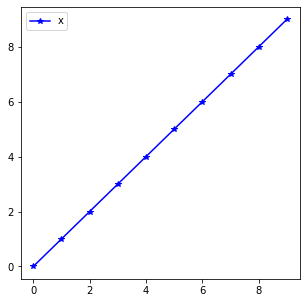

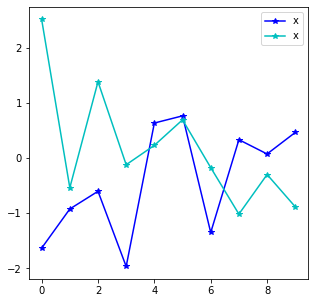

In [ ]:
# hide
a = TSeries(np.arange(10))
ax = show_graph(a)
test_graph_exists(ax)

a = TSeries(np.random.randn(2,10))[None,:]
ax = show_graph(a)
test_graph_exists(ax)

show_graph can show an array...

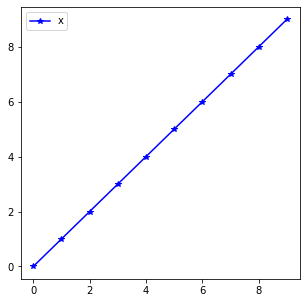

In [ ]:
a = np.arange(10)
ax = show_graph(a)

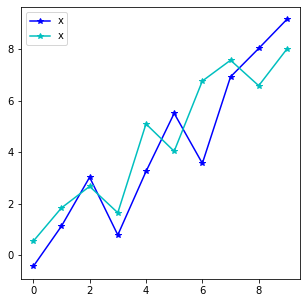

In [ ]:
a = tensor(np.arange(10)+np.random.randn(2,10))[None,:]
ax = show_graph(a)

In [ ]:
# export
class TensorSeq(TensorBase):
    def show(self, ctx=None, **kwargs):
        return show_graph(self, ctx=ctx, **kwargs)

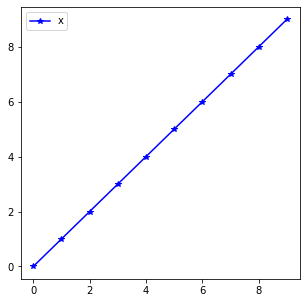

In [ ]:
ax = TensorSeq(np.arange(10)).show()

In [ ]:
# export
class TSTensorSeq(TensorSeq): pass
class TSTensorSeqy(TensorSeq):

    @classmethod
    def create(cls, t)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).float())

    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs:
            del kwargs['figsize']
        array = np.array(self.cpu())
        array = no_emp_dim(array)
        x_len = self._meta.get('x_len',0)
        m = self._meta.get('m','*g')
        label = self._meta.get('label','y')
        t = np.arange(x_len,x_len+array.shape[1])[None,:]
        ctx.plot(t.T, array.T, m, label=label, **kwargs)
        ctx.legend()
        return ctx

TSTensorSeqy.loss_func = MSELossFlat()

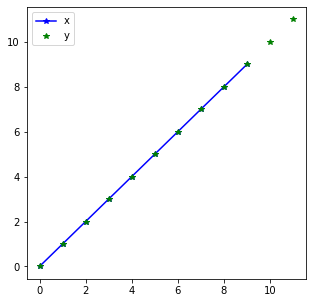

In [ ]:
ts = TSTensorSeq(np.arange(10))
ctx = ts.show()

y = TSTensorSeqy(np.arange(12))
y.show(ctx=ctx)

In [ ]:
#export
from fastai2.vision.data import *

@delegates(subplots)
def show_graphs(arrays, rows=None, cols=None, figsize=None, titles=None, **kwargs):
    "Show all images `arrays` as subplots with `rows` using `titles`"
    if titles is None: titles = [None]*len(arrays)
    axs = get_grid(len(arrays), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    for a,t,ax in zip(arrays, titles, axs):
        ctx = show_graph(a[0], ax=ax, title=t)
        for y in a[1:]:
            ctx = y.show(ctx=ctx)
    return axs

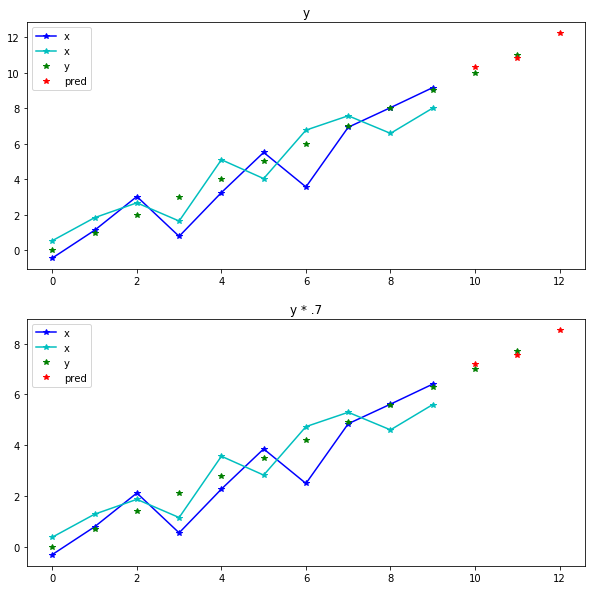

In [ ]:
y_hat = TSTensorSeqy(np.array([10.3,10.8,12.2]), x_len=10, m='*r', label='pred')

show_graphs(((a, y, y_hat), (a*.7, y*.7, y_hat*.7)), titles=('y','y * .7'), figsize=(10,10))

In [ ]:
# hide
test_graph_exists(ax)

## Multi Types

In [ ]:
class TSeries(TensorBase):pass

In [ ]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [ ]:
# export
import matplotlib.colors as mcolors
_colors = [v for k,v in mcolors.TABLEAU_COLORS.items()]
_colors += [v for k,v in mcolors.TABLEAU_COLORS.items()]# could be done better but ...
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = L(self._meta.get('m',_colors[:len(arrays)]))
        labels = L(self._meta.get('label',['x']*len(arrays)))
        if arrays.shape[-1] == 0:
            if len(labels):
                ctx.set_title(ctx.title._text +f"{labels} is empty")
            return ctx
        assert len(m)==len(labels)==len(arrays),f"{len(m)}=={len(labels)}=={len(arrays)}" 
        t = np.arange(array.shape[-1])        
        for a, c, label in zip(arrays, m, labels):            
            ls = ('-',None) if 'y' not in label else ('None','*' )
            ctx.plot(t, a, ls = ls[0], marker = ls[1], c=c, 
                     **kwargs, label=label)
        ctx.legend()
        return ctx
class TensorSeqsX(TensorSeqs):pass

In [ ]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])
print(a, a.shape)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]) torch.Size([2, 10])


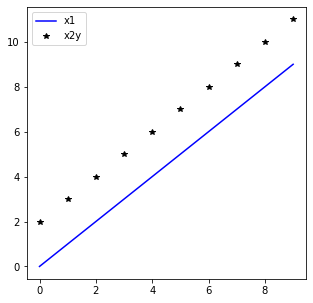

In [ ]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

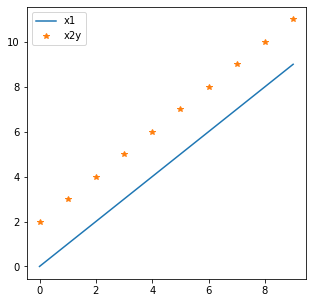

In [ ]:
# hide
# adding extra dim before to see if it than still works
TensorSeqs(a[None,:], label = ['x1','x2y']).show()

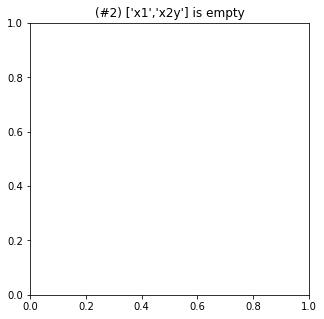

In [ ]:
# hide
# empty
TensorSeqs(np.ones([1,10,0]), label = ['x1','x2y']).show()

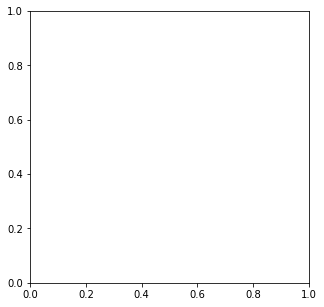

In [ ]:
# hide
test_fail(TensorSeqs(torch.randn(2,10), m='b', label = ['x1','y2']).show)

In [ ]:
# export
def _get_its_shape(o):    
    if len(o.shape) == 0: return 1, o[None]
    return len(o), o
    

class TensorCon(TSeries):
    _name = 'Constant'
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        l, its = _get_its_shape(self)
        dct = {k:np.round(its[i].item(),2) for k,i in zip(L(self._meta.get('label',self._name)),range(l))}
        if dct == {}:
            dct = ''
        ax.set_title(ax.title._text +f"{dct}")
        return ax

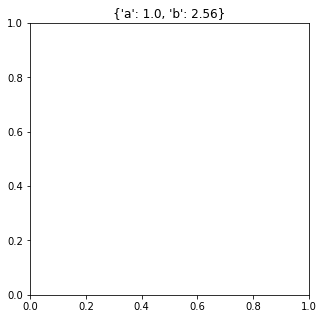

In [ ]:
TensorCon([1, 2.5555555555555], label=['a','b']).show()

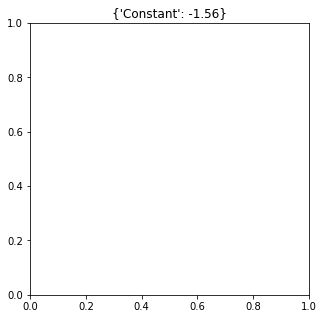

In [ ]:
TensorCon([[-1.5607],
        [-1.5607],
        [-1.5607],
        [-1.5607],
        [ 0.8909],
        [ 0.8909],
        [ 0.8909],
        [ 0.8909],
        [-0.0499],
        [-0.0499],
        [-0.0499],
        [-0.0499],
        [ 0.7197],
        [ 0.7197],
        [ 0.7197],
        [ 0.7197]]).show()

In [ ]:
# export
class TensorCat():  
    _name = 'Catagory' 
    def __init__(self, o, label= None):
        if isinstance(o, TensorCat):
            o, label = o.o, o._meta['label']
        self.o = L(o)    
        self._meta ={'label': ifnone(label, ['Catagory_'+str(i) for i in range(len(self.o))])}
        self.shape = (len(o),)
    def _dct(self):
        return {k:v for k,v in zip(self._meta['label'],self.o)}
    
    def __repr__(self):
        return f"TensorCat({list(self.o)}, label = {list(self._meta['label'])})"
    
    def __eq__(self, o):
        if isinstance(o, TensorCat):
            return self.o == self.o
        return False
    
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))            
        dct = self._dct()
        if dct == {}:
            dct = ''
        ax.set_title(ax.title._text +f"{dct}")
        return ax
    


2


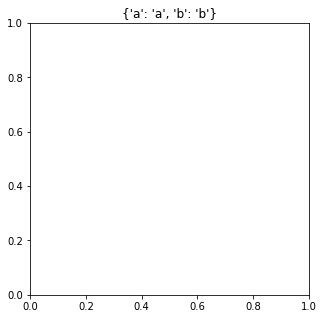

In [ ]:
a =  TensorCat(TensorCat(['a','b'], label=['a','b']))
a.show()

In [ ]:
a == TensorCat(['a','b'], label=['a','b'])

True

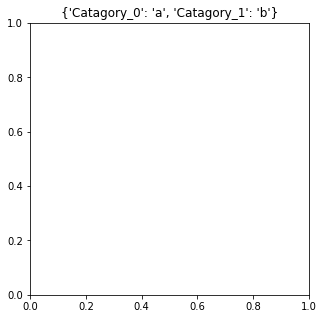

In [ ]:
a = TensorCat(['a','b'])
a.show()

In [ ]:
print(a)

TensorCat(['a', 'b'], label = ['Catagory_0', 'Catagory_1'])


## MultiTuple

In [ ]:
# export
class MultiTuple(Tuple):
    """The same as `Tuple` only stores the types in `_types` and if _meta stores those in `_meta`"""
    def __new__(cls, x, *rest, **kwargs):
        r = Tuple.__new__(cls,x, *rest)
        r._meta = {i:a._meta for i,a in enumerate(L(r)) if hasattr(a,'_meta')}
        r._types = [type(a) for a in L(r)]
        return r

In [ ]:
o = MultiTuple(1)
o, o._meta, o._types

((1), {}, [int])

In [ ]:
a = TensorBase(tensor(1), label='x')
b = TensorBase(tensor(1), label='y')
print(a._meta)
o = MultiTuple((a,b))
o, getattr(o,'_meta',None), o._types

{'label': 'x'}


((TensorBase(1), TensorBase(1)),
 {0: {'label': 'x'}, 1: {'label': 'y'}},
 [fastai2.torch_core.TensorBase, fastai2.torch_core.TensorBase])

In [ ]:
# hide
test_eq(o._meta,{0: {'label': 'x'}, 1: {'label': 'y'}})
test_eq(o._types,[TensorBase, TensorBase])
o = MultiTuple(1)
test_eq(o._meta,{})
test_eq(o._types,[int])

In [ ]:
# export
from fastai2.vision.data import get_grid
def _show_multituple(t, ax):
    for o in t:
        ax = o.show(ctx = ax)
    return ax

def get_ax(ax, ctx, figsize, **kwargs):
    ax = ifnone(ax,ctx)
    if ax is None:
        _, ax = plt.subplots(figsize=figsize, **kwargs)
    return ax

@delegates(plt.subplots)
def show_mt(self, ax = None, ctx=None, figsize = (10,10), **kwargs):
    ax = get_ax(ax, ctx, figsize, **kwargs)
    return _show_multituple(self, ax)   
MultiTuple.show = show_mt

In [ ]:
show_doc(MultiTuple.show,name='MultiTuple.show')

<h4 id="MultiTuple.show" class="doc_header"><code>MultiTuple.show</code><a href="__main__.py#L14" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiTuple.show</code>(**`ax`**=*`None`*, **`ctx`**=*`None`*, **`figsize`**=*`(10, 10)`*, **`nrows`**=*`1`*, **`ncols`**=*`1`*, **`sharex`**=*`False`*, **`sharey`**=*`False`*, **`squeeze`**=*`True`*, **`subplot_kw`**=*`None`*, **`gridspec_kw`**=*`None`*)



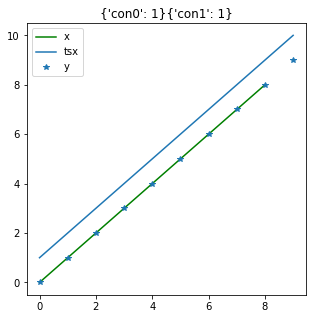

In [ ]:
x,xts,a,b = TensorSeqs(np.arange(9)[None,:],label=['x'],m=['g']),TensorSeqs(np.arange(1,11)[None,:],label=['tsx']), TensorCon(1,label=['con0']),TensorCon(1, label=['con1'], m='r')
y = TensorSeqs(np.arange(10)[None,:],label=['y'])
MultiTuple(x,xts,a,b,y).show(figsize = (5,5))

# Preprocces functions

## M4

In [ ]:
# export
def ts_lists(ts:np.ndarray)-> L:
    """Transforms a `np.ndarray` of shape (timeseries, max_time) to a list of timeseries with shape (1,time).

    where:

    max_time = the length of the longest timeserie

    time = the length of the non-nan values of that specific timeserie
    """
    lst = L()
    for time_series in ts:
        lst.append(time_series[~np.isnan(time_series)][None,:])
    return lst

In [ ]:
# hide
ts = np.array([np.arange(0,10.),
               np.arange(0,10.)
              ])
ts[1,-1] = np.NaN

r = ts_lists(ts)
test_eq(r[0],np.arange(0,10.)[None,:])
test_eq(r[1],np.arange(0,9.)[None,:])
test_eq(r[0].shape,(1,10))

In [ ]:
ts

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan]])

In [ ]:
ts_lists(ts)

(#2) [array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]),array([[0., 1., 2., 3., 4., 5., 6., 7., 8.]])]

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
